In [1]:
"""# authenticate google drive
from google.colab import drive
drive.mount('/content/drive')
"""

Mounted at /content/drive


In [ ]:
# install necessary libraries
#!pip install pyrsgis

In [2]:
# import all the required libraries
import os, glob, re, time
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from copy import deepcopy
from datetime import datetime

#os.chdir(r'/content/drive/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')
os.chdir(r'G:/My Drive/KathmanduUrbanGrowth/urban_growth_GWLR')

In [3]:
# define a function for alphanumeric filename sorting
def sorted_nicely(l): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [4]:
# read dataframe
df = pd.read_csv('210803_Kathmandu_UGM_GWLR.zip', compression='zip')
#df.columns = [a.split('@')[0] for a in df.keys()]

# generate built-up layers
for year in [2000, 2010, 2020]:
  df['%d_built'%year] = (df['%d_landcover' % (year)] == 1).astype(int)

df['growth_00_10'] = df['2010_built'] - df['2000_built']
df['growth_10_20'] = df['2020_built'] - df['2010_built']

df = df[sorted_nicely(df.keys())]

print(df.keys())

Index(['2000_AD_K5', '2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9',
       '2000_BD_K11', '2000_BD_K13', '2000_VD_K5', '2000_built',
       '2000_dist_builtup', '2000_landcover', '2000_r1_dist', '2000_r2_dist',
       '2000_r3_dist', '2010_AD_K5', '2010_BD_K3', '2010_BD_K5', '2010_BD_K7',
       '2010_BD_K9', '2010_BD_K11', '2010_BD_K13', '2010_VD_K5', '2010_built',
       '2010_dist_builtup', '2010_landcover', '2010_r1_dist', '2010_r2_dist',
       '2010_r3_dist', '2020_AD_K5', '2020_BD_K3', '2020_BD_K5', '2020_BD_K7',
       '2020_BD_K9', '2020_BD_K11', '2020_BD_K13', '2020_VD_K5', '2020_built',
       '2020_dist_builtup', '2020_landcover', '2020_r1_dist', '2020_r2_dist',
       '2020_r3_dist', 'dist_bus_stops', 'dist_hospitals', 'dist_hotels',
       'dist_institutes', 'dist_water', 'elevation', 'growth_00_10',
       'growth_10_20', 'latitudes', 'longitudes', 'slope'],
      dtype='object')


[Text(0.5, 0, '2000_BD_K3'),
 Text(1.5, 0, '2000_BD_K5'),
 Text(2.5, 0, '2000_BD_K7'),
 Text(3.5, 0, '2000_BD_K9'),
 Text(4.5, 0, '2000_BD_K11'),
 Text(5.5, 0, '2000_BD_K13'),
 Text(6.5, 0, '2000_VD_K5'),
 Text(7.5, 0, '2000_AD_K5'),
 Text(8.5, 0, '2000_dist_builtup'),
 Text(9.5, 0, '2000_r1_dist'),
 Text(10.5, 0, '2000_r2_dist'),
 Text(11.5, 0, '2000_r3_dist'),
 Text(12.5, 0, 'dist_bus_stops'),
 Text(13.5, 0, 'dist_hospitals'),
 Text(14.5, 0, 'dist_institutes'),
 Text(15.5, 0, 'dist_hotels'),
 Text(16.5, 0, 'dist_water'),
 Text(17.5, 0, 'elevation'),
 Text(18.5, 0, 'slope')]

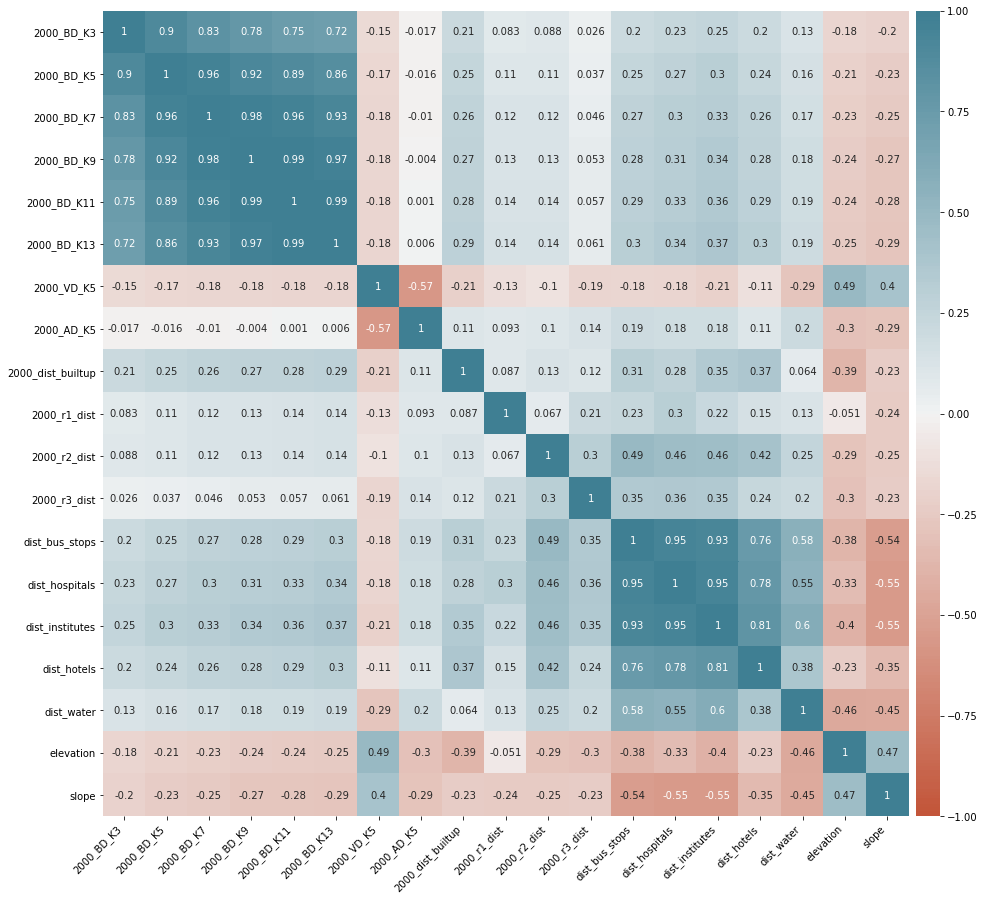

In [5]:
fig = None
ax = None

# create dataframe for epoch 1 
df_epoch1 = df[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_built', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
       '2000_r1_dist', '2000_r2_dist', '2000_r3_dist', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope', 'growth_00_10']]

# extract non-builtup cells only and remove builtup column
df_epoch1 = df_epoch1.loc[df_epoch1['2000_built'] == 0]
growth_00_10 = df_epoch1['growth_00_10']
df_epoch1.drop(['2000_built', 'growth_00_10'], axis=1, inplace=True)

# plot correlation matrix for epoch 1
corr1 = df_epoch1.corr()
corr1 = np.round(corr1, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (15, 15))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr1,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

#plt.savefig(r'Images/%s_CorrMat_Epoch1_PT_V2.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
#plt.show()

In [6]:
corr1[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1).loc[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']]

dist_bus_stops     0.961000
dist_hospitals     0.966333
dist_institutes    0.961333
dtype: float64

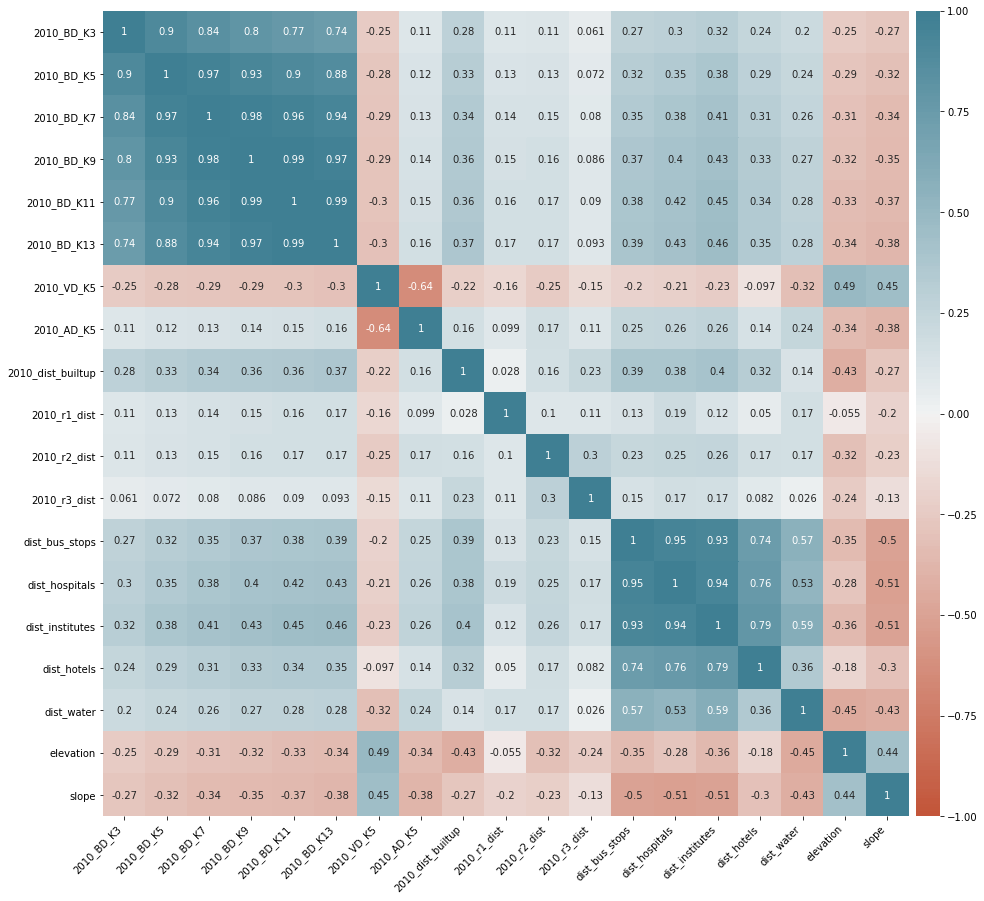

In [7]:
fig = None
ax = None

# create dataframe for epoch 1 
df_epoch2 = df[['2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_built', '2010_VD_K5', '2010_AD_K5', '2010_dist_builtup',
       '2010_r1_dist', '2010_r2_dist', '2010_r3_dist', 'dist_bus_stops', 
       'dist_hospitals', 'dist_institutes', 'dist_hotels', 'dist_water', 'elevation', 
       'slope', 'growth_10_20']]

# extract non-builtup cells only and remove builtup column
df_epoch2 = df_epoch2.loc[df_epoch2['2010_built'] == 0]
growth_10_20 = df_epoch2['growth_10_20']
df_epoch2.drop(['2010_built', 'growth_10_20'], axis=1, inplace=True)

# plot correlation matrix for epoch 1
corr2 = df_epoch2.corr()
corr2 = np.round(corr2, 3)

# increase figure size
fig, ax = plt.subplots(figsize = (15, 15))

# adjust the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

sns.heatmap(
    ax=ax,
    data=corr2,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    cbar_ax = cax
    )
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

#plt.savefig(r'Images/%s_CorrMat_Epoch2_PT_V2.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
plt.show()

In [8]:
corr2[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']].mean(axis=1).loc[['dist_bus_stops', 'dist_hospitals', 'dist_institutes']]

dist_bus_stops     0.959667
dist_hospitals     0.964000
dist_institutes    0.959000
dtype: float64

## Remove highly correlated features and class balance the data

In [9]:
# remove the ones with correlation more than 0.75
# retain dist_institutes because that has the highest correlation with distance to bus stops, hospitals and hotels
df_epoch1_reduced = df_epoch1[['2000_BD_K3', '2000_BD_K5', '2000_BD_K7', '2000_BD_K9', '2000_BD_K11',
       '2000_BD_K13', '2000_VD_K5', '2000_AD_K5', '2000_dist_builtup',
       '2000_r1_dist', '2000_r2_dist', '2000_r3_dist', 
       'dist_hospitals', 'dist_hotels', 'dist_water', 'elevation', 
       'slope']]

df_epoch2_reduced = df_epoch2[['2010_BD_K3', '2010_BD_K5', '2010_BD_K7', '2010_BD_K9', '2010_BD_K11',
       '2010_BD_K13', '2010_VD_K5', '2010_AD_K5', '2010_dist_builtup',
       '2010_r1_dist', '2010_r2_dist', '2010_r3_dist',
       'dist_hospitals', 'dist_hotels', 'dist_water', 'elevation', 
       'slope']]

## Class balance the features for epoch 1
# Separate and balance the classes
built_features = df_epoch1_reduced.loc[growth_00_10==1]
built_labels = growth_00_10.loc[growth_00_10==1]

unbuilt_features = df_epoch1_reduced.loc[growth_00_10==0]
unbuilt_labels = growth_00_10.loc[growth_00_10==0]

print('Epoch 1 - Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Downsample the majority class
unbuilt_features = resample(unbuilt_features,
                            replace = False, # sample without replacement
                            n_samples = built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(unbuilt_labels,
                          replace = False, # sample without replacement
                          n_samples = built_features.shape[0], # match minority n
                          random_state = 2)

print('Epoch 1 - Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Combine the balanced features
df_epoch1_reduced = pd.concat([built_features, unbuilt_features], axis=0)
growth_00_10_bal = pd.concat([built_labels, unbuilt_labels], axis=0)

## Class balance the features for epoch 2
# Separate and balance the classes
built_features = df_epoch2_reduced.loc[growth_10_20==1]
built_labels = growth_10_20.loc[growth_10_20==1]

unbuilt_features = df_epoch2_reduced.loc[growth_10_20==0]
unbuilt_labels = growth_10_20.loc[growth_10_20==0]

print('\nEpoch 2 - Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Downsample the majority class
unbuilt_features = resample(unbuilt_features,
                            replace = False, # sample without replacement
                            n_samples = built_features.shape[0], # match minority n
                            random_state = 2)

unbuilt_labels = resample(unbuilt_labels,
                          replace = False, # sample without replacement
                          n_samples = built_features.shape[0], # match minority n
                          random_state = 2)

print('Epoch 2 - Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built_labels.shape[0], unbuilt_labels.shape[0]))

# Combine the balanced features
df_epoch2_reduced = pd.concat([built_features, unbuilt_features], axis=0)
growth_10_20_bal = pd.concat([built_labels, unbuilt_labels], axis=0)

Epoch 1 - Number of records in each class:
Built: 70529, Unbuilt: 856020
Epoch 1 - Number of records in balanced classes:
Built: 70529, Unbuilt: 70529

Epoch 2 - Number of records in each class:
Built: 53042, Unbuilt: 802978
Epoch 2 - Number of records in balanced classes:
Built: 53042, Unbuilt: 53042


## Check distribution of features

In [10]:
# compute mean and standard deviation for both the epochs separately
mean_vals_e1 = df_epoch1_reduced.mean(axis=0)
std_vals_e1 = df_epoch1_reduced.std(axis=0)

mean_vals_e2 = df_epoch2_reduced.mean(axis=0)
std_vals_e2 = df_epoch2_reduced.std(axis=0)

# standarise data for both the epochs
for covariate in df_epoch1_reduced.keys():
    df_epoch1_reduced[covariate] = (df_epoch1_reduced[covariate] - mean_vals_e1[covariate]) / std_vals_e1[covariate]
    
for covariate in df_epoch2_reduced.keys():
    #print(covariate, round(mean_vals_e2[covariate], 3), round(std_vals_e2[covariate]))
    df_epoch2_reduced[covariate] = (df_epoch2_reduced[covariate] - mean_vals_e2[covariate]) / std_vals_e2[covariate]
    
df_epoch1_reduced.describe()

,2000_BD_K3,2000_BD_K5,2000_BD_K7,2000_BD_K9,2000_BD_K11,2000_BD_K13,2000_VD_K5,2000_AD_K5,2000_dist_builtup,2000_r1_dist,2000_r2_dist,2000_r3_dist,dist_hospitals,dist_hotels,dist_water,elevation,slope
count,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05,1.410580e+05
mean,2.417874e-17,9.510306e-17,-7.334219e-17,5.641707e-17,1.128341e-17,-3.546216e-17,1.837584e-16,-1.458784e-16,-2.885330e-16,1.430576e-16,-2.385636e-16,2.512574e-16,-5.480515e-17,1.023567e-16,-8.148236e-16,-6.044686e-17,-1.644155e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.483471e-01,-5.037283e-01,-5.301943e-01,-5.464807e-01,-5.579563e-01,-5.665408e-01,-7.852382e-01,-6.503144e-01,-5.254053e+00,-4.433931e+00,-4.266866e+00,-3.052568e+00,-3.770020e+00,-4.059346e+00,-3.930720e+00,-2.281937e+00,-1.187501e+00
25%,-4.483471e-01,-5.037283e-01,-5.301943e-01,-5.464807e-01,-5.579563e-01,-5.665408e-01,-7.852382e-01,-6.503144e-01,-2.038736e-01,-2.323977e-01,-1.682557e-01,-2.615379e-01,-6.808432e-01,-5.322896e-01,-2.866126e-01,-5.906968e-01,-8.171038e-01
50%,-4.483471e-01,-5.037283e-01,-5.301943e-01,-5.464807e-01,-5.098749e-01,-4.978988e-01,-7.852382e-01,-6.503144e-01,4.808964e-01,3.431658e-01,4.204970e-01,4.688655e-01,3.800733e-01,3.036980e-01,3.901504e-01,-4.280047e-01,-3.607599e-01
75%,-4.483471e-01,-1.586796e-02,7.389274e-02,1.034921e-01,1.151837e-01,1.198792e-01,9.387029e-01,6.880342e-01,6.092912e-01,6.510693e-01,5.902847e-01,6.494071e-01,8.334916e-01,7.731534e-01,6.677966e-01,2.719491e-01,6.666051e-01
max,5.470299e+00,5.350596e+00,5.269041e+00,5.231055e+00,5.211815e+00,5.199388e+00,1.749969e+00,3.067321e+00,6.520890e-01,8.501281e-01,6.936200e-01,6.994447e-01,1.066847e+00,1.172245e+00,8.586784e-01,4.759221e+00,5.643624e+00


In [11]:
df_epoch2_reduced.describe()

,2010_BD_K3,2010_BD_K5,2010_BD_K7,2010_BD_K9,2010_BD_K11,2010_BD_K13,2010_VD_K5,2010_AD_K5,2010_dist_builtup,2010_r1_dist,2010_r2_dist,2010_r3_dist,dist_hospitals,dist_hotels,dist_water,elevation,slope
count,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05,1.060840e+05
mean,1.457469e-16,5.572674e-17,8.573345e-17,1.971869e-16,8.573345e-18,5.144007e-17,1.157402e-16,-1.671802e-16,-1.607502e-15,8.701945e-16,-2.529137e-16,5.486941e-16,-1.028801e-16,9.859346e-16,7.030143e-16,6.430009e-17,-4.286672e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.629644e-01,-6.361451e-01,-6.716117e-01,-6.943249e-01,-7.110695e-01,-7.242652e-01,-7.002079e-01,-8.458987e-01,-6.665445e+00,-4.849703e+00,-4.277501e+00,-3.478015e+00,-3.829512e+00,-4.094754e+00,-3.943222e+00,-2.282575e+00,-1.219104e+00
25%,-5.629644e-01,-6.361451e-01,-6.716117e-01,-6.943249e-01,-7.110695e-01,-7.242652e-01,-7.002079e-01,-8.458987e-01,-1.405406e-01,-2.744310e-01,-1.509734e-01,2.881121e-03,-6.620399e-01,-5.065796e-01,-3.101009e-01,-5.891149e-01,-8.314745e-01
50%,-5.629644e-01,-6.361451e-01,-5.763285e-01,-5.234305e-01,-5.214550e-01,-5.077395e-01,-7.002079e-01,-8.458987e-01,4.526330e-01,2.817159e-01,3.607300e-01,3.964217e-01,3.654949e-01,3.057894e-01,3.885764e-01,-4.371852e-01,-3.385575e-01
75%,2.358722e-02,3.254867e-01,3.765036e-01,3.880067e-01,4.266176e-01,4.395604e-01,8.980053e-01,8.753565e-01,6.144072e-01,6.673136e-01,5.891809e-01,5.308260e-01,8.021989e-01,7.411626e-01,6.855142e-01,3.595192e-01,6.894532e-01
max,4.129448e+00,3.979688e+00,3.901982e+00,3.862861e+00,3.839679e+00,3.822775e+00,1.797000e+00,2.464208e+00,6.144072e-01,9.565122e-01,7.288570e-01,5.903819e-01,1.148270e+00,1.262486e+00,8.776503e-01,4.595023e+00,5.009858e+00


In [12]:
# Use the following mean and std for scaling features for prediction
epoch2_mean_std = pd.concat([mean_vals_e2, std_vals_e2], axis=1)
epoch2_mean_std.columns = ['mean', 'sd']

print(epoch2_mean_std)
#epoch2_mean_std.to_csv(r'output\%s_Kathmandu_Epoch2_Mean_SD_PT_V1.csv' % (datetime.now().strftime('%y%m%d')))

                       mean        sd
2010_BD_K3         0.106643  0.189431
2010_BD_K5         0.132305  0.207980
2010_BD_K7         0.143849  0.214184
2010_BD_K9         0.150477  0.216725
2010_BD_K11        0.154962  0.217928
2010_BD_K13        0.158340  0.218622
2010_VD_K5         0.280396  0.400447
2010_AD_K5         0.255550  0.302105
2010_dist_builtup  0.918030  0.133412
2010_r1_dist       0.835261  0.172229
2010_r2_dist       0.854414  0.199746
2010_r3_dist       0.854886  0.245797
dist_hospitals     0.769321  0.200893
dist_hotels        0.764340  0.186663
dist_water         0.817948  0.207431
elevation          0.331893  0.144698
slope              0.179344  0.147112


<ipython-input-11-547d086d6c24>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


[Text(-6.0, 0, ''),
 Text(-4.0, 0, ''),
 Text(-2.0, 0, ''),
 Text(0.0, 0, ''),
 Text(2.0, 0, ''),
 Text(4.0, 0, ''),
 Text(6.0, 0, ''),
 Text(8.0, 0, '')]

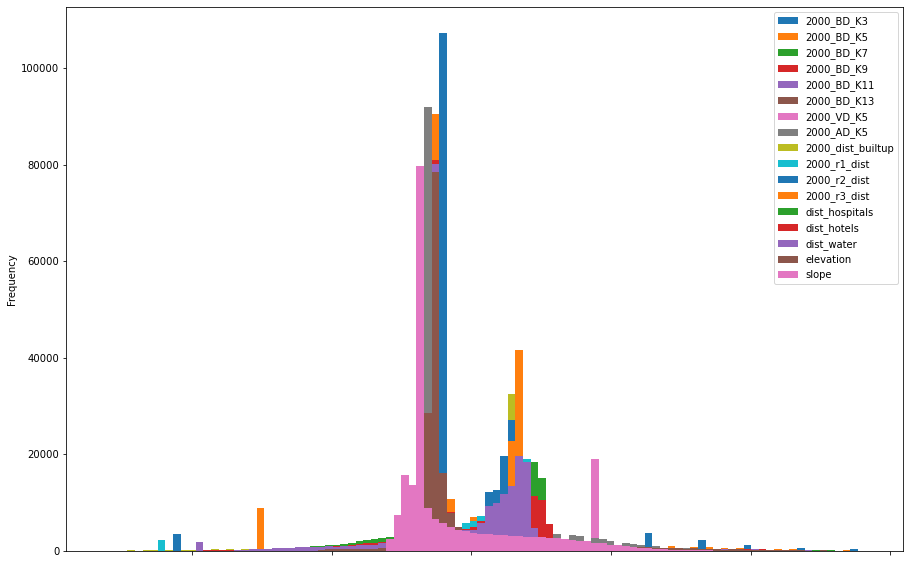

In [11]:
# plot the figure to check the distribution
fig, ax = plt.subplots(figsize=(15, 10))
df_epoch1_reduced.plot.hist(ax=ax, bins=100)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## Grid search to find the best Lasso Logistic Model for both epochs

In [13]:
# perform the grid search to find the right parameters
param_grid = [
    {'C': [1, 2, 3, 4, 5]}
]

# set up grid search for the Epoch 2
logit_epoch1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
grid_search_epoch1 = GridSearchCV(logit_epoch1, param_grid, cv=5, scoring='f1', n_jobs=-1)

# set up grid search for the Epoch 2
logit_epoch2 = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
grid_search_epoch2 = GridSearchCV(logit_epoch2, param_grid, cv=5, scoring='f1', n_jobs=-1)

# run the grid search for both the epochs
grid_search_epoch1.fit(df_epoch1_reduced, growth_00_10_bal)
grid_search_epoch2.fit(df_epoch2_reduced, growth_10_20_bal)

# print the best params
print(grid_search_epoch1.best_params_)
print(grid_search_epoch2.best_params_)

{'C': 2}
{'C': 5}


# Feature Selection Using Lasso Regression

In [14]:
# perform feature selection using Lasso Model for epoch 1
sel_e1 = SelectFromModel(LogisticRegression(C=2, penalty='l1', solver='liblinear'))
sel_e1.fit(df_epoch1_reduced, growth_00_10_bal)
selected_feat_e1 = df_epoch1_reduced.columns[(sel_e1.get_support())]

print('Total features for Epoch 1: {}'.format((df_epoch1_reduced.shape[1])))
print('Selected features for Epoch 1: {}'.format(len(selected_feat_e1)))

sel_e2 = SelectFromModel(LogisticRegression(C=5, penalty='l1', solver='liblinear'))
sel_e2.fit(df_epoch2_reduced, growth_10_20_bal)
selected_feat_e2 = df_epoch2_reduced.columns[(sel_e2.get_support())]

print('Total features for Epoch 2: {}'.format((df_epoch1_reduced.shape[1])))
print('Selected features for Epoch 2: {}'.format(len(selected_feat_e1)))

lasso_importances_e1 = pd.Series(sel_e1.estimator_.coef_.flatten(), index=df_epoch1_reduced.columns)
lasso_importances_e2 = pd.Series(sel_e2.estimator_.coef_.flatten(), index=df_epoch2_reduced.columns)

Total features for Epoch 1: 17
Selected features for Epoch 1: 17
Total features for Epoch 2: 17
Selected features for Epoch 2: 17


In [15]:
for name, coef in zip(df_epoch1_reduced.columns, sel_e1.estimator_.coef_.flatten()):
  print(name, '\t', np.round(coef, 3))

2000_BD_K3 	 0.375
2000_BD_K5 	 0.174
2000_BD_K7 	 0.014
2000_BD_K9 	 -0.002
2000_BD_K11 	 0.189
2000_BD_K13 	 0.425
2000_VD_K5 	 -0.386
2000_AD_K5 	 -0.2
2000_dist_builtup 	 0.577
2000_r1_dist 	 0.23
2000_r2_dist 	 -0.046
2000_r3_dist 	 -0.12
dist_hospitals 	 0.591
dist_hotels 	 0.159
dist_water 	 0.123
elevation 	 -0.513
slope 	 -0.374


<ipython-input-16-d6111a26a7be>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(


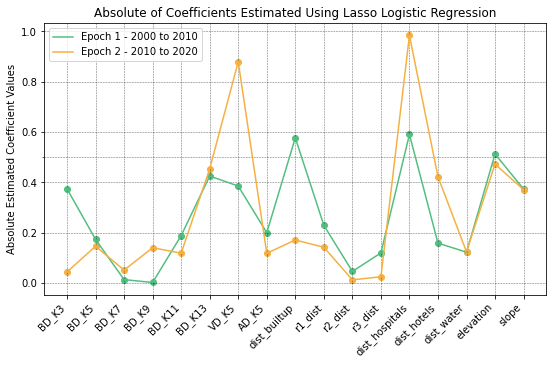

In [16]:
fig, ax = plt.subplots(figsize = (9, 5))

# plot the coefficients for both the epochs
ax.scatter(x=[a.split('2000_')[-1] for a in lasso_importances_e1.index], 
           y=np.abs(lasso_importances_e1.values), color='#52BE80')
plt.plot(np.abs(lasso_importances_e1.values), color='#52BE80', label='Epoch 1 - 2000 to 2010')

ax.scatter(x=[a.split('2010_')[-1] for a in lasso_importances_e2.index], 
           y=np.abs(lasso_importances_e2.values), color='#F5B041')
plt.plot(np.abs(lasso_importances_e2.values), color='#F5B041', label='Epoch 2 - 2010 to 2020')

# add titles
ax.set_title("Absolute of Coefficients Estimated Using Lasso Logistic Regression")
ax.set_ylabel("Absolute Estimated Coefficient Values")

# correct the x axis labels and rotate 45 degree
_ = ax.set_xticklabels(
    [a.split('2010_')[-1] for a in lasso_importances_e2.index],
    rotation=45,
    horizontalalignment='right'
)

ax.legend(loc='upper left')
plt.rc('legend', fontsize=12)

ax.grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.6)
ax.grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

#plt.savefig(r'Images/%s_Coefficient_LassoLogit_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)

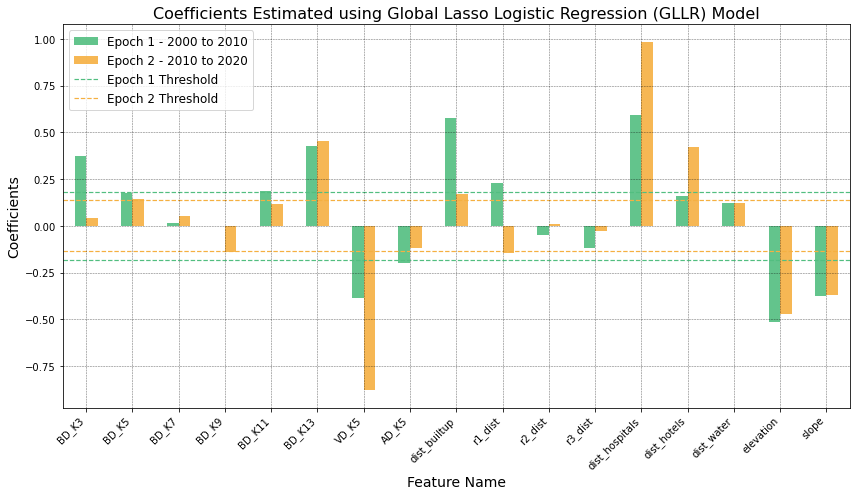

In [17]:
#std_epoch1 = np.std([tree.feature_importances_ for tree in lr_epoch1.estimators_], axis=0)
lasso_importances_e1_plot = deepcopy(lasso_importances_e1)
lasso_importances_e1_plot.index = lasso_importances_e1.index.str.replace('2000_', '')

#std_epoch2 = np.std([tree.feature_importances_ for tree in lr_epoch2.estimators_], axis=0)
lasso_importances_e2_plot = deepcopy(lasso_importances_e2)
lasso_importances_e2_plot.index = lasso_importances_e2.index.str.replace('2010_', '')

fig, ax = plt.subplots(figsize = (12, 7))

#importance_df = pd.concat([lr_importances_epoch1.abs(), lr_importances_epoch2.abs()], axis=1)
importance_df = pd.concat([lasso_importances_e1_plot, lasso_importances_e2_plot], axis=1)
importance_df.columns = ['Epoch 1 - 2000 to 2010', 'Epoch 2 - 2010 to 2020']

importance_df.plot.bar(ax=ax, y=["Epoch 1 - 2000 to 2010", "Epoch 2 - 2010 to 2020"], 
                       color={"Epoch 1 - 2000 to 2010":'#52BE80', "Epoch 2 - 2010 to 2020":'#F5B041'}, alpha=0.9)

# add threshold line for epoch 1 and 2
ax.axhline(y=0.18, c="#52BE80", linestyle='--', linewidth=1.2, zorder=1, label='Epoch 1 Threshold')
ax.axhline(y=-0.18, c="#52BE80", linestyle='--', linewidth=1.2, zorder=1)
ax.axhline(y=0.136, c="#F5B041", linestyle='--', linewidth=1.2, zorder=1, label='Epoch 2 Threshold')
ax.axhline(y=-0.136, c="#F5B041", linestyle='--', linewidth=1.2, zorder=1)

ax.set_title("Coefficients Estimated using Global Lasso Logistic Regression (GLLR) Model", fontsize=16)
ax.set_ylabel("Coefficients", fontsize=14)
ax.set_xlabel("Feature Name", fontsize=14)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
# reorder legend entries
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 3, 0, 1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          loc='upper left')
plt.rc('legend', fontsize=12)

ax.grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.2)
ax.grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
#ax.xaxis.grid(False)

#plt.savefig(r'Images/%s_GLLR_FeatImportance_BothEpochs_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)
fig.tight_layout()

In [18]:
# Epoch 1 - loop through feature importance arranged in ascending order
abs_importance_e1 = np.abs(lasso_importances_e1)

pscore_dict_e1 = dict()
rscore_dict_e1 = dict()
fscore_dict_e1 = dict()

for covariate in abs_importance_e1.sort_values(ascending=True).index:
    filtered_series = abs_importance_e1.loc[abs_importance_e1 >= abs_importance_e1[covariate]]
    
    print('\nRetaining %d features:' % (filtered_series.shape[0]))
    print('Dropping', abs_importance_e1.loc[abs_importance_e1 < abs_importance_e1[covariate]].index.values)
    #print(filtered_series)
    
    # K-Fold cross validation of logit model
    sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    x_e1, y_e1 = df_epoch1_reduced[filtered_series.index].to_numpy(), growth_00_10_bal.to_numpy()

    p_score_list = []
    r_score_list = []
    f1_score_list = []

    n = 1
    for train_index, test_index in sk_fold.split(x_e1, y_e1):
        #print('\nEvaluating fold number', n)
        x_train, x_test = x_e1[train_index], x_e1[test_index]
        y_train, y_test = y_e1[train_index], y_e1[test_index]

        lr_e1 = LogisticRegression(C=4, n_jobs=-1)
        lr_e1.fit(x_train, y_train)

        y_pred = lr_e1.predict(x_test)
        c_matrix = confusion_matrix(y_test, y_pred)
        p_score = precision_score(y_test, y_pred)
        r_score = recall_score(y_test, y_pred)
        f_score = f1_score(y_test, y_pred)

        #print('Confusion matrix:\n', c_matrix)
        #print('F1-Score:', f_score)

        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f_score)

        n += 1

    print('Precision, Recall and F1 Score:', np.mean(p_score_list), np.mean(r_score_list), np.mean(f1_score_list))
    
    pscore_dict_e1[filtered_series.shape[0]] = np.mean(p_score_list)
    rscore_dict_e1[filtered_series.shape[0]] = np.mean(r_score_list)
    fscore_dict_e1[filtered_series.shape[0]] = np.mean(f1_score_list)


Retaining 17 features:
Dropping []
Precision, Recall and F1 Score: 0.8112995319283645 0.8580866928793001 0.8340340177317958

Retaining 16 features:
Dropping ['2000_BD_K9']
Precision, Recall and F1 Score: 0.8112261196935548 0.8581008712431168 0.8340019116375492

Retaining 15 features:
Dropping ['2000_BD_K7' '2000_BD_K9']
Precision, Recall and F1 Score: 0.811337703110755 0.8581150566433424 0.8340676127483446

Retaining 14 features:
Dropping ['2000_BD_K7' '2000_BD_K9' '2000_r2_dist']
Precision, Recall and F1 Score: 0.8112514727458129 0.8582993733625586 0.8341088198397395

Retaining 13 features:
Dropping ['2000_BD_K7' '2000_BD_K9' '2000_r2_dist' '2000_r3_dist']
Precision, Recall and F1 Score: 0.8106767340147384 0.8595754622933175 0.8344073186610759

Retaining 12 features:
Dropping ['2000_BD_K7' '2000_BD_K9' '2000_r2_dist' '2000_r3_dist' 'dist_water']
Precision, Recall and F1 Score: 0.8107830064681709 0.8590083126626258 0.83419567812869

Retaining 11 features:
Dropping ['2000_BD_K7' '2000_

In [19]:
# Epoch 2 - loop through feature importance arranged in ascending order
abs_importance_e2 = np.abs(lasso_importances_e2)

pscore_dict_e2 = dict()
rscore_dict_e2 = dict()
fscore_dict_e2 = dict()

for covariate in abs_importance_e2.sort_values(ascending=True).index:
    filtered_series = abs_importance_e2.loc[abs_importance_e2 >= abs_importance_e2[covariate]]
    
    print('\nRetaining %d features:' % (filtered_series.shape[0]))
    print('Dropping', abs_importance_e2.loc[abs_importance_e2 < abs_importance_e2[covariate]].index.values)
    #print(filtered_series)
    
    # K-Fold cross validation of logit model
    sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    x_e2, y_e2 = df_epoch2_reduced[filtered_series.index].to_numpy(), growth_10_20_bal.to_numpy()

    p_score_list = []
    r_score_list = []
    f1_score_list = []

    n = 1
    for train_index, test_index in sk_fold.split(x_e2, y_e2):
        #print('\nEvaluating fold number', n)
        x_train, x_test = x_e2[train_index], x_e2[test_index]
        y_train, y_test = y_e2[train_index], y_e2[test_index]

        lr_e2 = LogisticRegression(C=5, n_jobs=-1)
        lr_e2.fit(x_train, y_train)

        y_pred = lr_e2.predict(x_test)
        c_matrix = confusion_matrix(y_test, y_pred)
        p_score = precision_score(y_test, y_pred)
        r_score = recall_score(y_test, y_pred)
        f_score = f1_score(y_test, y_pred)

        #print('Confusion matrix:\n', c_matrix)
        #print('F1-Score:', f_score)

        p_score_list.append(p_score)
        r_score_list.append(r_score)
        f1_score_list.append(f_score)

        n += 1

    print('Precision, Recall and F1 Score:', np.mean(p_score_list), np.mean(r_score_list), np.mean(f1_score_list))
    
    pscore_dict_e2[filtered_series.shape[0]] = np.mean(p_score_list)
    rscore_dict_e2[filtered_series.shape[0]] = np.mean(r_score_list)
    fscore_dict_e2[filtered_series.shape[0]] = np.mean(f1_score_list)


Retaining 17 features:
Dropping []
Precision, Recall and F1 Score: 0.8206551261610132 0.895912704031851 0.8566297341284418

Retaining 16 features:
Dropping ['2010_r2_dist']
Precision, Recall and F1 Score: 0.8206751239000333 0.8959504114224994 0.8566580599566752

Retaining 15 features:
Dropping ['2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.8207604932583651 0.8961200893489932 0.8567820372203236

Retaining 14 features:
Dropping ['2010_BD_K3' '2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.820733522406719 0.8960446816762625 0.8567329045027463

Retaining 13 features:
Dropping ['2010_BD_K3' '2010_BD_K7' '2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.8207273647797892 0.8960069760627556 0.8567123274965223

Retaining 12 features:
Dropping ['2010_BD_K3' '2010_BD_K7' '2010_AD_K5' '2010_r2_dist' '2010_r3_dist']
Precision, Recall and F1 Score: 0.8212170641243499 0.8951774419027527 0.856599188623988

Retaining 11 features:
Dropping ['2010_BD_K3

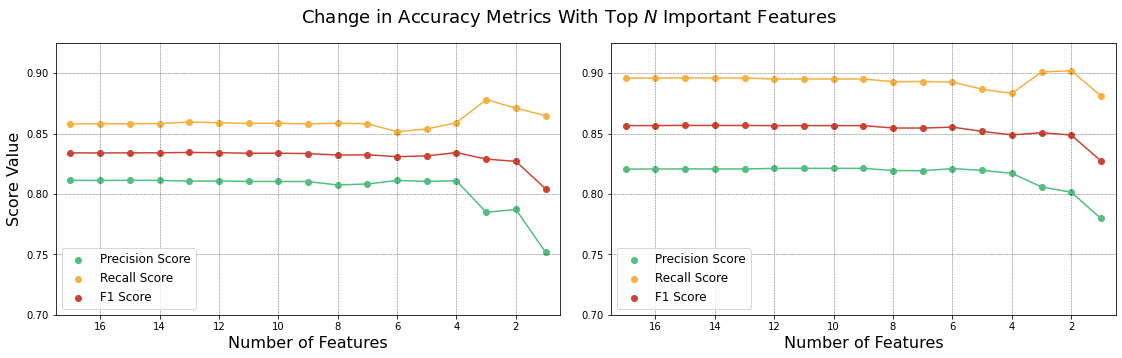

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (19, 5))

# plot points for Epoch 1
ax[0].scatter(x=list(pscore_dict_e1.keys()), y=list(pscore_dict_e1.values()),
          color='#52BE80', label='Precision Score')
ax[0].plot(list(pscore_dict_e1.keys()), list(pscore_dict_e1.values()), color='#52BE80')

ax[0].scatter(x=list(rscore_dict_e1.keys()), y=list(rscore_dict_e1.values()),
          color='#F5B041', label='Recall Score')
ax[0].plot(list(rscore_dict_e1.keys()), list(rscore_dict_e1.values()), color='#F5B041')

ax[0].scatter(x=list(fscore_dict_e1.keys()), y=list(fscore_dict_e1.values()),
          color='#CB4335', label='F1 Score')
ax[0].plot(list(fscore_dict_e1.keys()), list(fscore_dict_e1.values()), color='#CB4335')

#pscore_dict_e2 = {key:pscore_dict_e2[key] for key in sorted(pscore_dict_e2, reverse=True)}

# plot points for Epoch 2
ax[1].scatter(x=list(pscore_dict_e2.keys()), y=list(pscore_dict_e2.values()),
          color='#52BE80', label='Precision Score')
ax[1].plot(list(pscore_dict_e2.keys()), list(pscore_dict_e2.values()), color='#52BE80')

ax[1].scatter(x=list(rscore_dict_e2.keys()), y=list(rscore_dict_e2.values()),
          color='#F5B041', label='Recall Score')
ax[1].plot(list(rscore_dict_e2.keys()), list(rscore_dict_e2.values()), color='#F5B041')

ax[1].scatter(x=list(fscore_dict_e2.keys()), y=list(fscore_dict_e2.values()),
          color='#CB4335', label='F1 Score')
ax[1].plot(list(fscore_dict_e2.keys()), list(fscore_dict_e2.values()), color='#CB4335')


# reverse the plots
for n in range(0, 2):
    ax[n].set_xlim(17.5, 0.5)
    ax[n].set_ylim(0.7, 0.925)

    ax[n].grid(color='black', linestyle='--', linewidth=0.5, which='minor', alpha=0.6)
    ax[n].grid(color='black', linestyle='--', linewidth=0.5, which='major', alpha=0.6)
    
    ax[n].set_xlabel("Number of Features", fontsize=16)

    ax[n].legend(loc='lower left')

ax[0].set_ylabel("Score Value", fontsize=16)
    
fig.subplots_adjust(wspace=0.1, hspace=0)
plt.suptitle('Change in Accuracy Metrics With Top $\it{N}$ Important Features', fontsize=18)
plt.rc('legend', fontsize=14)

#plt.savefig(r'Images/%s_NFeatures_Accuracies_5Fold_PT_V1.png' % (datetime.now().strftime('%y%m%d')), bbox_inches='tight', dpi=300)

In [21]:
# print the covariates in descending order of coef to find the value to draw line in the feature importance graph
print(abs_importance_e2.sort_values(ascending=False))

dist_hospitals       0.984354
2010_VD_K5           0.879327
elevation            0.472843
2010_BD_K13          0.454143
dist_hotels          0.422380
slope                0.370859
2010_dist_builtup    0.171387
2010_BD_K5           0.146500
2010_r1_dist         0.142425
2010_BD_K9           0.140671
dist_water           0.124294
2010_BD_K11          0.118685
2010_AD_K5           0.118345
2010_BD_K7           0.051505
2010_BD_K3           0.044312
2010_r3_dist         0.025101
2010_r2_dist         0.012870
dtype: float64


## Remove less important features, add lat and lon columns, export CSV

In [22]:
GLLR_coef = pd.concat([pd.Series(lasso_importances_e1_plot.index, index=lasso_importances_e1_plot.index), lasso_importances_e1_plot, lasso_importances_e2_plot], axis=1)
GLLR_coef.columns = ['FeatureName', 'Epoch1', 'Epoch2']

print(GLLR_coef)

                   FeatureName    Epoch1    Epoch2
BD_K3                    BD_K3  0.374637  0.044312
BD_K5                    BD_K5  0.173610  0.146500
BD_K7                    BD_K7  0.013734  0.051505
BD_K9                    BD_K9 -0.002445 -0.140671
BD_K11                  BD_K11  0.188805  0.118685
BD_K13                  BD_K13  0.425473  0.454143
VD_K5                    VD_K5 -0.385611 -0.879327
AD_K5                    AD_K5 -0.200323 -0.118345
dist_builtup      dist_builtup  0.577235  0.171387
r1_dist                r1_dist  0.229604 -0.142425
r2_dist                r2_dist -0.046356  0.012870
r3_dist                r3_dist -0.119929 -0.025101
dist_hospitals  dist_hospitals  0.590641  0.984354
dist_hotels        dist_hotels  0.158822  0.422380
dist_water          dist_water  0.122823  0.124294
elevation            elevation -0.512864 -0.472843
slope                    slope -0.373887 -0.370859


In [23]:
selected_epoch1_columns = abs_importance_e1.sort_values(ascending=False).head(9)
#print(selected_epoch1_columns)

selected_export_epoch1 = df_epoch1_reduced[selected_epoch1_columns.keys()]
selected_export_epoch1[['latitudes', 'longitudes', 'growth_00_10']] = df.loc[selected_export_epoch1.index, 
                                                                             ['latitudes', 'longitudes', 'growth_00_10']]

print(selected_export_epoch1.head())

     dist_hospitals  2000_dist_builtup  elevation  2000_BD_K13  2000_VD_K5  \
29        -3.598844           0.095713  -2.043574    -0.566541    0.735886   
50        -3.468881           0.480896  -1.237681    -0.429257   -0.785238   
59        -3.410457           0.138511  -1.476044    -0.566541   -0.785238   
60        -3.403891           0.095713  -1.468477    -0.566541   -0.785238   
135       -2.926889           0.480896  -1.513879    -0.394936   -0.785238   

     2000_BD_K3     slope  2000_r1_dist  2000_AD_K5  latitudes  longitudes  \
29    -0.448347  1.076065     -0.203145   -0.650314  3080610.8   320457.97   
50    -0.448347  2.206054      0.159338   -0.055493  3080610.8   321087.97   
59    -0.448347 -0.884327      0.314659    0.688034  3080610.8   321357.97   
60    -0.448347 -0.086006      0.331915    1.134150  3080610.8   321387.97   
135   -0.448347  0.217975      0.435780   -0.650314  3080610.8   323637.97   

     growth_00_10  
29              1  
50              1  
59

C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [24]:
selected_epoch2_columns = abs_importance_e2.sort_values(ascending=False).head(9)
#print(selected_epoch2_columns)

selected_export_epoch2 = df_epoch2_reduced[selected_epoch2_columns.keys()]
selected_export_epoch2[['latitudes', 'longitudes', 'growth_10_20']] = df.loc[selected_export_epoch2.index, 
                                                                             ['latitudes', 'longitudes', 'growth_10_20']]

print(selected_export_epoch2.head())

      dist_hospitals  2010_VD_K5  elevation  2010_BD_K13  dist_hotels  \
228        -2.409928   -0.700208   0.611500    -0.534805    -3.044683   
2260       -2.397562    0.498452   0.626323    -0.480674    -3.033744   
2263       -2.381055   -0.000990   0.689318    -0.507740    -3.004411   
2264       -2.375574    0.098899   0.655967    -0.561871    -2.994648   
2265       -2.370105    0.398564   0.615206    -0.670134    -2.984891   

         slope  2010_dist_builtup  2010_BD_K5  2010_r1_dist  latitudes  \
228   1.141028           0.560483   -0.251492     -0.532482  3080610.8   
2260  1.103542           0.560483   -0.251492     -0.500096  3080550.8   
2263 -0.144632           0.398708   -0.636145     -0.532482  3080550.8   
2264  0.767776           0.344783   -0.636145     -0.542920  3080550.8   
2265  0.644163           0.290858   -0.636145     -0.553530  3080550.8   

      longitudes  growth_10_20  
228    326427.97             1  
2260   326427.97             1  
2263   326517.97 

C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [39]:
#selected_export_epoch1.to_csv('%s_Kathmandu_Epoch1_GWLR_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)
#selected_export_epoch2.to_csv('%s_Kathmandu_Epoch2_GWLR_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)
#GLLR_coef.to_csv('%s_Kathmandu_GLLR_Coef_PT_V1.csv' % (datetime.now().strftime('%y%m%d')), index=False)